In [2]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pprint

from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP, COBYLA, CG
from qiskit.chemistry import QiskitChemistryError
from qiskit.chemistry.applications import MolecularGroundStateEnergy
from qiskit.chemistry.algorithms import ground_state_solvers
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.core import QubitMappingType
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType, HFMethodType

In [3]:
global qubit_mapping
qubit_mapping = 'jordan_wigner'
global two_qubit_reduction
two_qubit_reduction = False
global best_result
global hfmethod
hfmethod = HFMethodType.ROHF
global var_form
global vqe
global ferOp

In [4]:
backend = Aer.get_backend("statevector_simulator")
optimizer = COBYLA(maxiter=500)
distances = np.arange(0.7, 1.2, 0.1)
vqe_energies = []
min = 100.0
dismin = 0.0

for dist in distances:
    charge = 1
    spin = 2   
    alt=np.sqrt(dist**2 - (dist/2)**2)
    mol = "H .0 .0 .0; H .0 .0 " + str(dist) + "; H .0 " + str(alt) + " " + str(dist/2)
    driver = PySCFDriver(atom = mol,
                         unit=UnitsType.ANGSTROM, spin = spin,
                         charge=charge, basis='sto-6g',hf_method=hfmethod)
    
    molecule = driver.run()
    
    shift = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_orbitals = molecule.num_orbitals
    num_spin_orbitals = num_orbitals*2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    
    qubitOp = ferOp.mapping(map_type=qubit_mapping)
    
    initial_state = HartreeFock(num_spin_orbitals, 
                                num_particles, 
                                qubit_mapping,
                                two_qubit_reduction)
    
    var_form = UCCSD(num_orbitals=num_spin_orbitals,
                        num_particles=num_particles,
                        initial_state=initial_state,
                        qubit_mapping=qubit_mapping,
                        two_qubit_reduction=two_qubit_reduction)
    
    init_parm = np.zeros(var_form.num_parameters)
    vqe = VQE(qubitOp, var_form, optimizer, initial_point=init_parm)
    vqe_result_tot = vqe.run(backend)
    vqe_result = np.real(vqe_result_tot['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), 
          "VQE Result:", vqe_result)
    if vqe_result < min:
        min = vqe_result
        dismin = dist
        best_result = vqe_result_tot

Interatomic Distance: 0.7 VQE Result: -1.169942908649416
Interatomic Distance: 0.8 VQE Result: -1.243309199026035
Interatomic Distance: 0.9 VQE Result: -1.2748268158680711
Interatomic Distance: 1.0 VQE Result: -1.2811879870428409
Interatomic Distance: 1.1 VQE Result: -1.2722647616188205


I plot all the calculated energies. It's clearly visible an absolute minimum

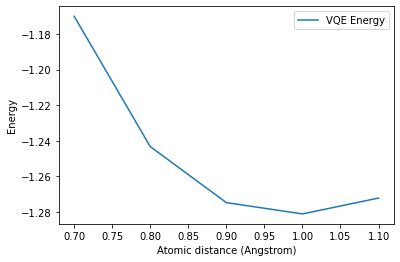

In [5]:
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
#plt.ylim([-1.5, -1.3])
plt.show()

### More VQE information

I print all informations, parameter values, eigenalues (ecc. ecc.) about the best iteration of the VQE algorithm. 

In [6]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(best_result)

{   'cost_function_evals': 141,
    'eigenstate': array([ 1.27739522e-16+2.99111260e-17j, -6.98605027e-16+1.18093618e-15j,
        2.15834199e-17-1.16124437e-16j, -9.91520885e-18+9.02911965e-17j,
       -1.93975641e-17-1.93552203e-18j,  3.53653212e-18+1.37290843e-17j,
       -5.91250332e-17-7.05684467e-17j, -1.57094620e-17-1.61930742e-16j,
       -2.63103770e-16+9.83980943e-16j,  9.85751722e-01-7.70146645e-15j,
        7.06248160e-02-2.71145455e-16j,  3.76762973e-16+6.06936677e-16j,
       -5.72052525e-06-1.03980927e-16j,  2.90652730e-16+5.96986264e-16j,
       -5.61327476e-17+3.59523165e-17j,  5.17440728e-17-6.18681357e-17j,
        8.59344087e-17-4.46503078e-17j,  7.06406056e-02-2.78588851e-16j,
       -9.33414078e-02+4.79657400e-16j, -2.02387664e-17-6.05877950e-17j,
       -1.80077487e-05+5.80417098e-17j,  1.06030128e-16+1.45914261e-17j,
       -9.15010323e-17-1.11914160e-16j, -4.09042414e-17-4.54277039e-17j,
       -1.78250000e-17+1.12924431e-16j,  4.84181241e-16+5.13188324e-16j,
 

This is the hamiltonian of H3+, qubit mapped and simplified.

In [7]:
pp.pprint(ferOp.mapping(qubit_mapping).simplify().print_details())

('IIIIII\t(-1.8908946110249365+0j)\n'
 'IIIIIZ\t(0.19349382990321673+0j)\n'
 'IIIIYY\t(-0.009394237621759498+0j)\n'
 'IIIIXX\t(-0.009394237621759498+0j)\n'
 'IIIIZI\t(-0.08755065787105569+0j)\n'
 'IIIZII\t(-0.08786432107997949+0j)\n'
 'IIZIII\t(0.19349382990321667+0j)\n'
 'IYYIII\t(-0.009394237621759496+0j)\n'
 'IXXIII\t(-0.009394237621759496+0j)\n'
 'IZIIII\t(-0.08755065787105569+0j)\n'
 'ZIIIII\t(-0.08786432107997948+0j)\n'
 'IIIIZZ\t(0.10110563235490364+0j)\n'
 'IIIZIZ\t(0.10110489952143713+0j)\n'
 'IIIZYY\t(-2.194841959860666e-05+0j)\n'
 'IIIZXX\t(-2.194841959860666e-05+0j)\n'
 'IIZIIZ\t(0.14087037255619309+0j)\n'
 'IIZIYY\t(0.0022725090147004403+0j)\n'
 'IIZIXX\t(0.0022725090147004403+0j)\n'
 'IIZYZY\t(7.62212768512624e-05+0j)\n'
 'IIZXZX\t(7.62212768512624e-05+0j)\n'
 'IXXIIZ\t(0.0022725090147004408+0j)\n'
 'IYYIIZ\t(0.0022725090147004408+0j)\n'
 'IXXIYY\t(0.035495132738992144+0j)\n'
 'IYYIYY\t(0.035495132738992144+0j)\n'
 'IXXIXX\t(0.035495132738992144+0j)\n'
 'IYYIXX\t(0.035495

UCCSD variational form just consider some (the ones that conserve number of particles and spin) single and double excitations:

In [8]:
print(var_form.single_excitations)
print(var_form.double_excitations)

[[0, 1], [0, 2], [3, 4], [3, 5]]
[[0, 1, 3, 4], [0, 1, 3, 5], [0, 2, 3, 4], [0, 2, 3, 5]]
